In [1]:
from wmin.api import API

from super_net.covmats import sqrt_covmat_jax

import jax.scipy.linalg as jla
import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt

import ultranest
from ultranest.plot import cornerplot

In [2]:
inp = {
    "dataset_inputs": [{'dataset':'NMC'},
{'dataset': 'SLACP_dwsh'},
{'dataset': 'SLACD_dw_ite'},
# {'dataset': 'BCDMSP_dwsh'},
# {'dataset': 'BCDMSD_dw_ite'},
# {'dataset': 'CHORUSNUPb_dw_ite'},
# {'dataset': 'CHORUSNBPb_dw_ite'},
# {'dataset': 'NTVNUDMNFe_dw_ite', 'cfac': ['MAS']},
# {'dataset': 'NTVNBDMNFe_dw_ite', 'cfac': ['MAS']},
{'dataset': 'HERACOMBNCEM'} ,
{'dataset': 'HERACOMBNCEP575'},
{'dataset': 'HERACOMBNCEP820'},
{'dataset': 'HERACOMBNCEP920'},
{'dataset': 'HERACOMBNCEP460'},
# {'dataset': 'HERACOMBCCEP'},
# {'dataset': 'HERACOMBCCEM'} ,
# {'dataset':'HERACOMB_SIGMARED_B'},
# {'dataset': 'HERACOMB_SIGMARED_C'}
                      ],
    
    "theoryid": 400,
    "use_cuts": "internal",
    
    # wmin basis specs
    "wminpdfset": "210623_mnc_disonly_linear_1000",
    "n_replicas_wmin": 15,
    
    # Level 0 closure test
    "fakedata": True,
    "pseudodata": False, 
    "closure_test_pdf": "210623_mnc_disonly_linear_1000",
    
    # fit specs
    "use_t0": True,
    "t0pdfset": "210623_mnc_disonly_linear_1000",
    
    "bayesian_fit": True,
    "wmin_grid_index": 1, # random seed used for random parametrisation of wmin pdf
#     "replica_index": 1,  # random seed used for random noise to central values
    "trval_index": 1
}


In [3]:
data_values = API.make_data_values(**inp)

LHAPDF 6.5.0 loading /Users/markcostantini/miniconda3/envs/new_jax_env/share/LHAPDF/210623_mnc_disonly_linear_1000/210623_mnc_disonly_linear_1000_0000.dat
210623_mnc_disonly_linear_1000 PDF set, member #0, version 1


In [4]:
pred_data = API.make_pred_data(**inp)

In [5]:
def make_chi2(make_data_values, make_pred_data):
    """
    TODO
    """
    training_data = make_data_values.training_data
    central_values = training_data.central_values
    covmat = training_data.covmat
    central_values_idx = training_data.central_values_idx

    @jax.jit
    def chi2(pdf):
        """
        TODO
        """
        diff = (
            make_pred_data(pdf)[central_values_idx]
            - central_values
        )

        sqrt_covmat = jnp.array(sqrt_covmat_jax(covmat))

        # solve_triangular: solve the equation a x = b for x, assuming a is a triangular matrix.
        chi2_vec = jla.solve_triangular(sqrt_covmat, diff, lower=True)
        loss = jnp.sum(chi2_vec**2)
        return loss

    return chi2

chi2 = make_chi2(data_values, pred_data)

In [20]:
weight_minimization_grid = API.weight_minimization_grid(**inp)


def prior_transform(cube):
    # uniform prior on wmin weights
    params = cube.copy()    
    for i in range(inp["n_replicas_wmin"]-1):
        params[i] = cube[i] * 1.2 - 0.6
    return params

    

In [21]:
print(dir(weight_minimization_grid))
print(weight_minimization_grid.wmin_INPUT_GRID.shape)
print(weight_minimization_grid.wmin_central_replica)
print(weight_minimization_grid.wmin_basis_idx)

['INPUT_GRID', '__annotations__', '__class__', '__dataclass_fields__', '__dataclass_params__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__match_args__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'init_wmin_weights', 'to_dict', 'wmin_INPUT_GRID', 'wmin_basis_idx', 'wmin_central_replica']
(15, 14, 50)
310
[776 926 290 476 775 311 725 541 296 788 165 171 668 898]


In [22]:
parameters = [f"b{i}" for i in range(inp["n_replicas_wmin"]-1)]

@jax.jit
def log_likelihood(wmin_weights):
    
    wmin_weights = jnp.concatenate((jnp.array([1.0]), wmin_weights))

    pdf = jnp.einsum(
            "i,ijk", wmin_weights, weight_minimization_grid.wmin_INPUT_GRID
        )
    
    return - chi2(pdf) * 0.5

sampler = ultranest.ReactiveNestedSampler(
    parameters,
    log_likelihood, 
    prior_transform,
)


############
type(cube) = <class 'numpy.ndarray'>
############
type(cube) = <class 'numpy.ndarray'>
############
type(cube) = <class 'numpy.ndarray'>
############
type(cube) = <class 'numpy.ndarray'>


In [9]:
type(sampler)

ultranest.integrator.ReactiveNestedSampler

In [10]:
import time
t0 = time.time()
result = sampler.run(
            min_num_live_points=400, 
            min_ess=50, 
            widen_before_initial_plateau_num_warn=10000,
            widen_before_initial_plateau_num_max=50000
)
print(time.time() - t0)

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1  05 [-2.3139..-2.3132]*| it/evals=5582/50608 eff=11.1178% N=400  
[ultranest] Likelihood function evaluations: 50614
[ultranest]   logZ = -11.39 +- 0.1042
[ultranest] Effective samples strategy satisfied (ESS = 3021.7, need >50)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.12 bs:0.10 tail:0.01 total:0.10 required:<0.50
[ultranest] done iterating.
648.100634098053


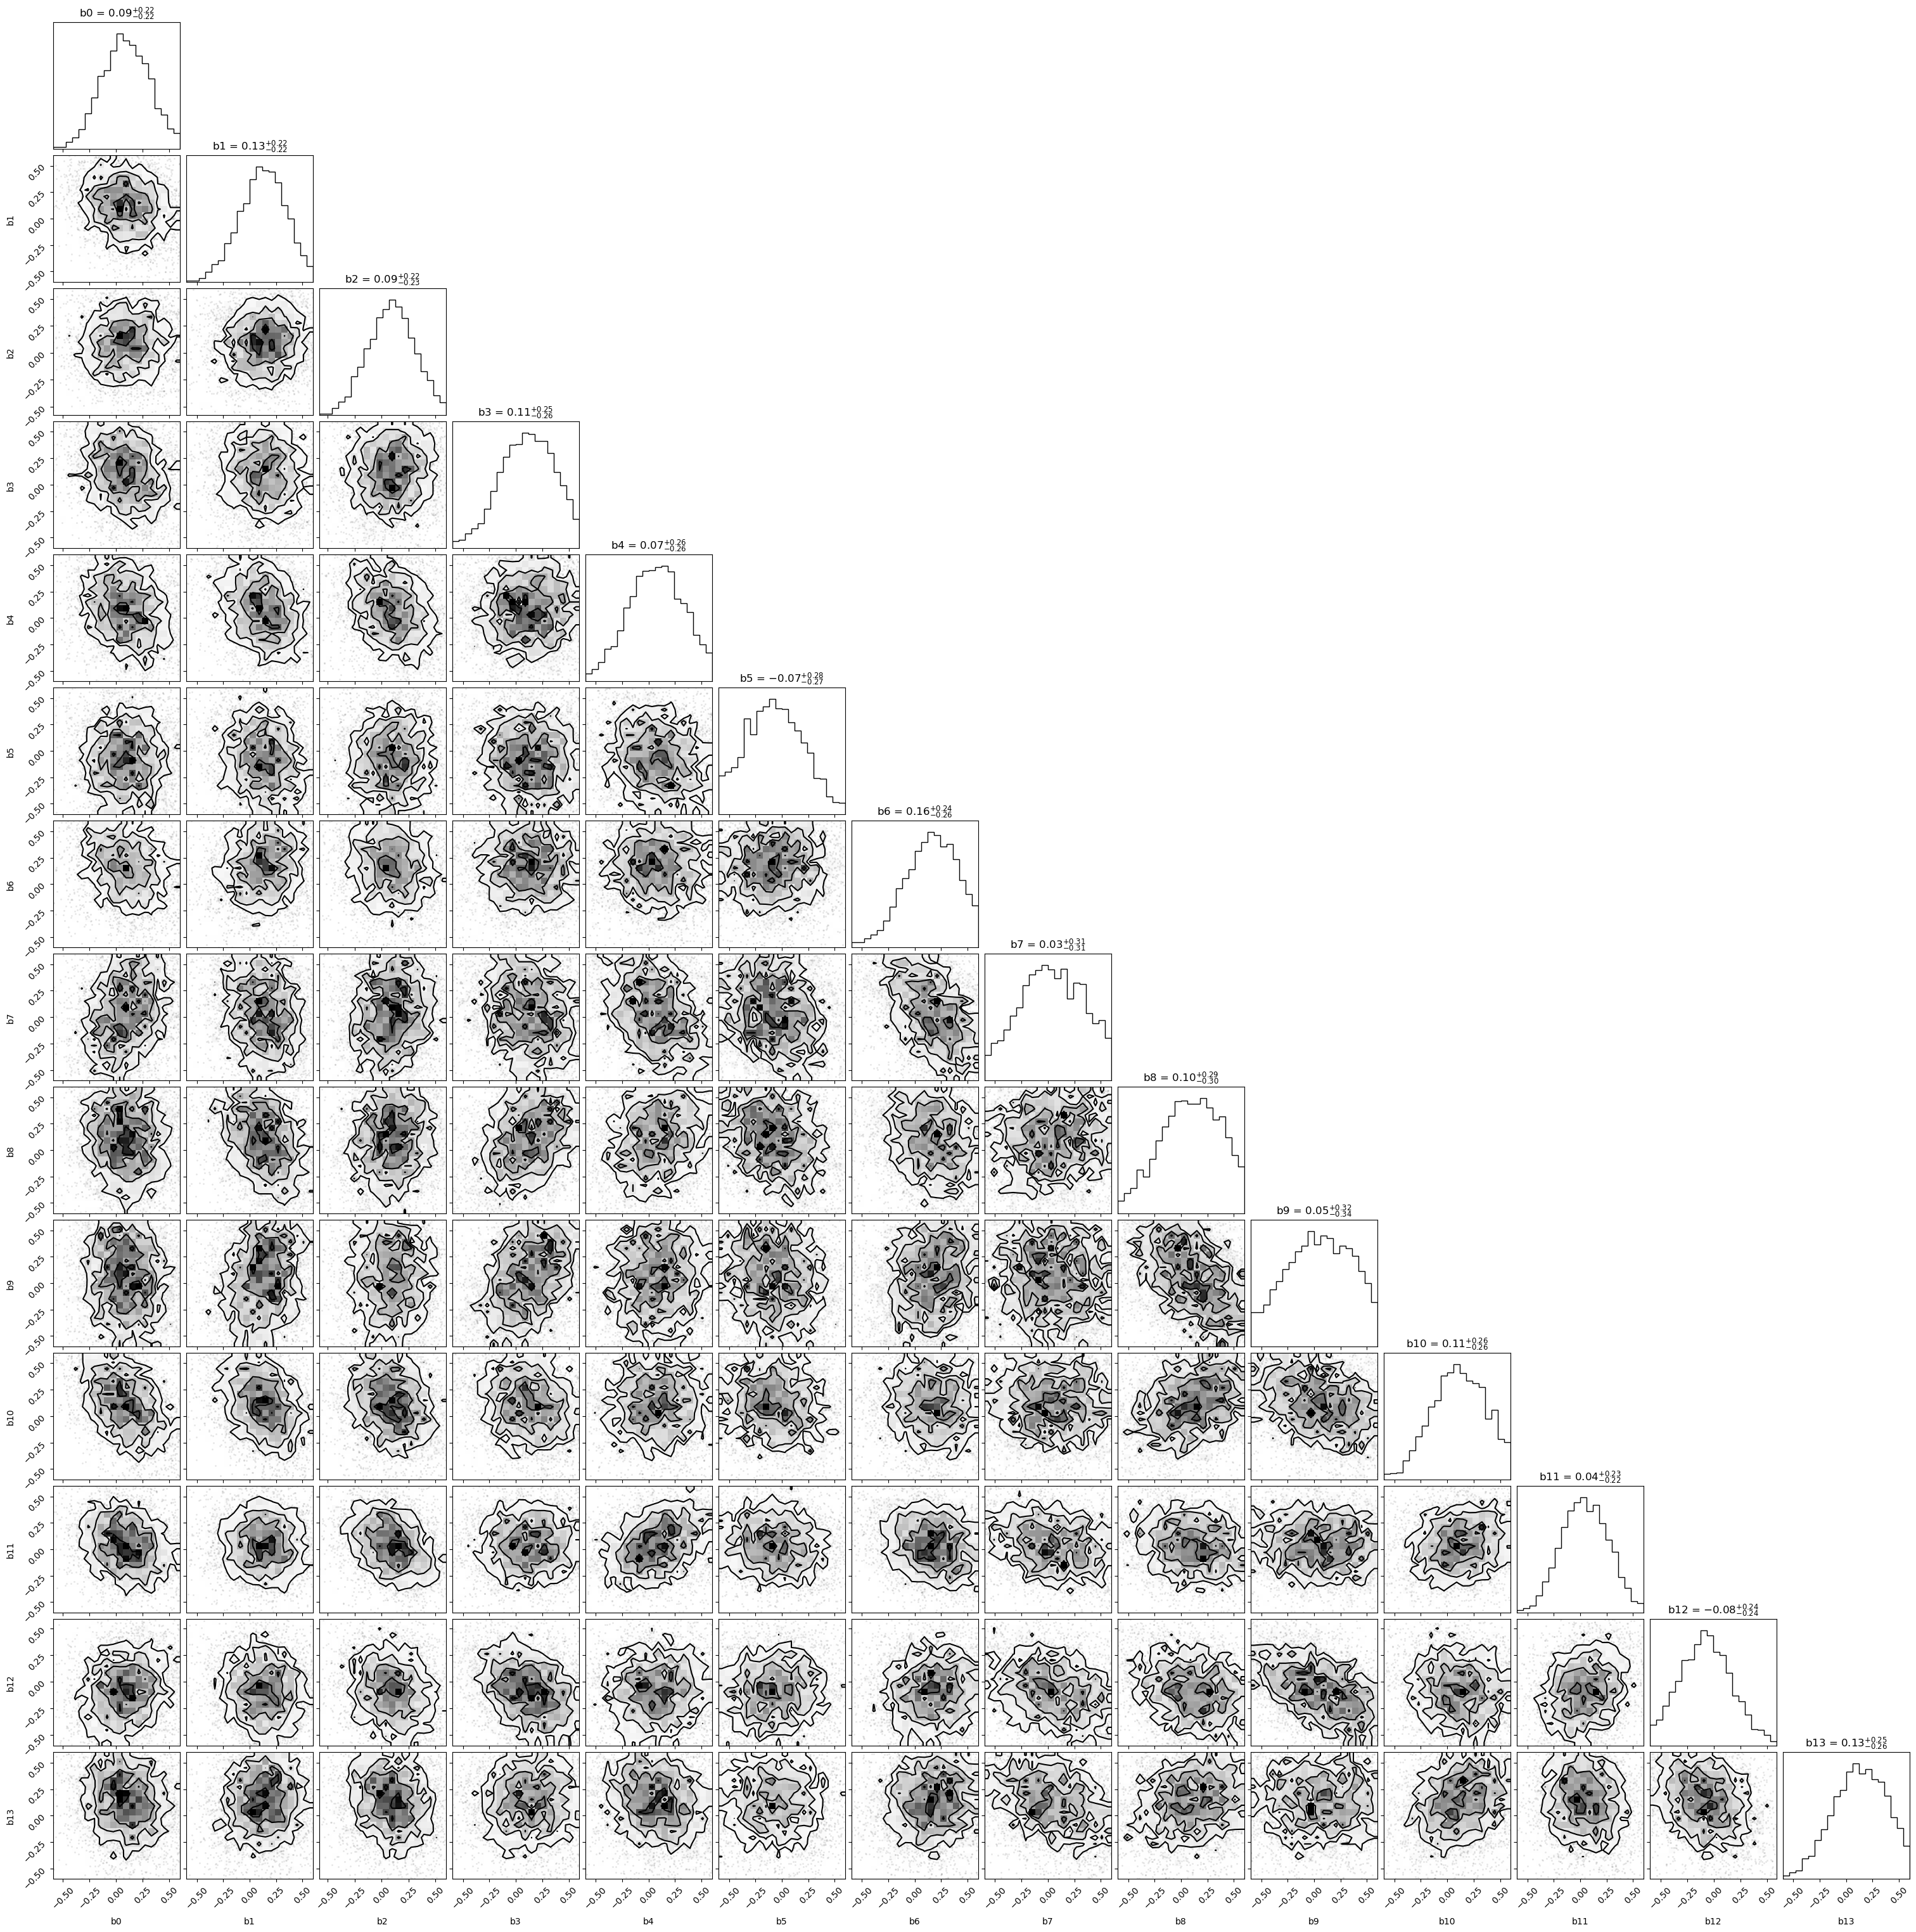

In [11]:
cornerplot(sampler.results)

In [12]:
wmin_pdfs = []
for sample in result['samples']:
    
    opt_weights = jnp.concatenate((jnp.array([1.0]), jnp.array(sample)))
                              
    pdf = jnp.einsum(
                "i,ijk", opt_weights, weight_minimization_grid.wmin_INPUT_GRID
            )
    wmin_pdfs.append(pdf)


In [13]:
nnpdfs = weight_minimization_grid.INPUT_GRID

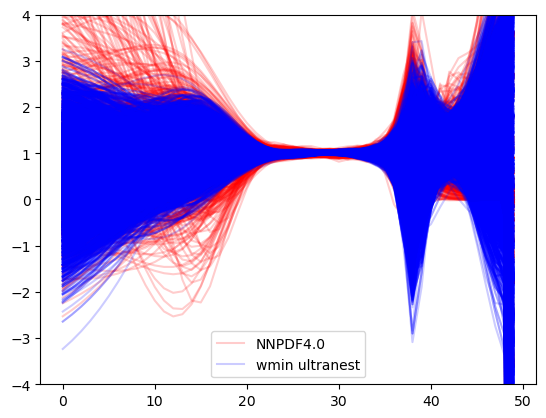

In [14]:
fl=2
fig, ax = plt.subplots()

for nnpdf in nnpdfs:
    ax.plot(nnpdf[fl] / nnpdfs.mean(axis=0)[fl], "red", alpha = 0.2)

ax.plot([],[], "red", alpha = 0.2, label="NNPDF4.0")

for wmin_pdf in wmin_pdfs:
    ax.plot(wmin_pdf[fl] / nnpdfs.mean(axis=0)[fl], "blue", alpha = 0.2)
    
ax.plot([], [], "blue", alpha = 0.2, label="wmin ultranest")

ax.set_ylim([-4,4])
ax.legend()

In [24]:
result['samples'].shape

(5986, 14)

In [31]:
print(result['samples'].shape)
print(result['weighted_samples']['logl'].shape)
print(result['weighted_samples']['upoints'].shape)


(5986, 14)
(5986,)
(5986, 14)


In [66]:

def resample_with_matching_variance(samples, n_samples, max_iterations=10000, tolerance=1e-5):
    original_variance = jnp.var(samples)
    print('###############')
    print(f'original variance = {original_variance}')
    
    current_samples = samples.copy()
    rng = jax.random.PRNGKey(1)
    
    for _ in range(max_iterations):
        
        resampled_samples = jax.random.choice(rng, len(samples), (n_samples,), replace=True)

        # Calculate the variance of the resampled samples
        resampled_variance = jnp.var(current_samples[resampled_samples])
        
        # Check if the variance of the resampled samples is close to the original
        if jnp.abs(resampled_variance / original_variance -1) < tolerance:
            return current_samples[resampled_samples]
    
    # If the desired variance match is not found, you may raise an exception or handle it as needed.
    raise Exception("Matching variance not achieved within the maximum iterations.")

# Example usage

n_samples = 1000  # Number of samples in the resampled set

resampled_samples = resample_with_matching_variance(result['samples'], n_samples, max_iterations=1000, tolerance=1e-2)


###############
original variance = 0.06516357511281967


In [67]:
jnp.abs(jnp.var(resampled_samples) / 0.06516357)

Array(0.99106926, dtype=float32)

In [68]:
wmin_pdfs = []
for sample in resampled_samples:
    
    opt_weights = jnp.concatenate((jnp.array([1.0]), jnp.array(sample)))
                              
    pdf = jnp.einsum(
                "i,ijk", opt_weights, weight_minimization_grid.wmin_INPUT_GRID
            )
    wmin_pdfs.append(pdf)

In [72]:
fl=2
fig, ax = plt.subplots()

for nnpdf in nnpdfs:
    ax.plot(nnpdf[fl] / nnpdfs.mean(axis=0)[fl], "red", alpha = 0.2)

ax.plot([],[], "red", alpha = 0.2, label="NNPDF4.0")

for wmin_pdf in wmin_pdfs:
    ax.plot(wmin_pdf[fl] / nnpdfs.mean(axis=0)[fl], "blue", alpha = 0.2)
    
ax.plot([], [], "blue", alpha = 0.2, label="wmin ultranest")

ax.set_ylim([-4,4])
ax.legend()
fig.savefig('delme.pdf')


<Figure size 640x480 with 1 Axes>
